In [1]:
from pathlib import Path

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.continuous import Lorenz63
from dynamics_discovery.dataset import TimeSeriesDataset
from dynamics_discovery.preprocessing import add_noise, downsample, standardize
from matplotlib_utils.axes_setters import set_labels
from matplotlib_utils.plots import comparisonplot


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

## Generate dataset

In [2]:
lorenz = Lorenz63()
dt = 0.01
t = jnp.arange(10000) * dt

seed = 10
u0 = jax.random.normal(jax.random.PRNGKey(seed), shape=(2, lorenz.dim))
u = jax.vmap(lambda u0_: lorenz.solve(jnp.asarray([0, 500]), u0_, max_steps=None))(u0)
u = jax.vmap(lambda u0_: lorenz.solve(500 + t, u0_, max_steps=None))(u[:, 1])

In [3]:
dataset = TimeSeriesDataset(500 + t, u, metadata=dict())

In [4]:
datadir = Path("../../data")
dataset.save(datadir / "lorenz63_new_test.hdf5")

## Import generated dataset and discard the transient portion

In [2]:
datadir = Path("../../data")
dataset_loaded = TimeSeriesDataset.load(datadir / "lorenz63_new.hdf5")

Text(0.5, 0.98, 'Lorenz63 data with increasing Gaussian noise')

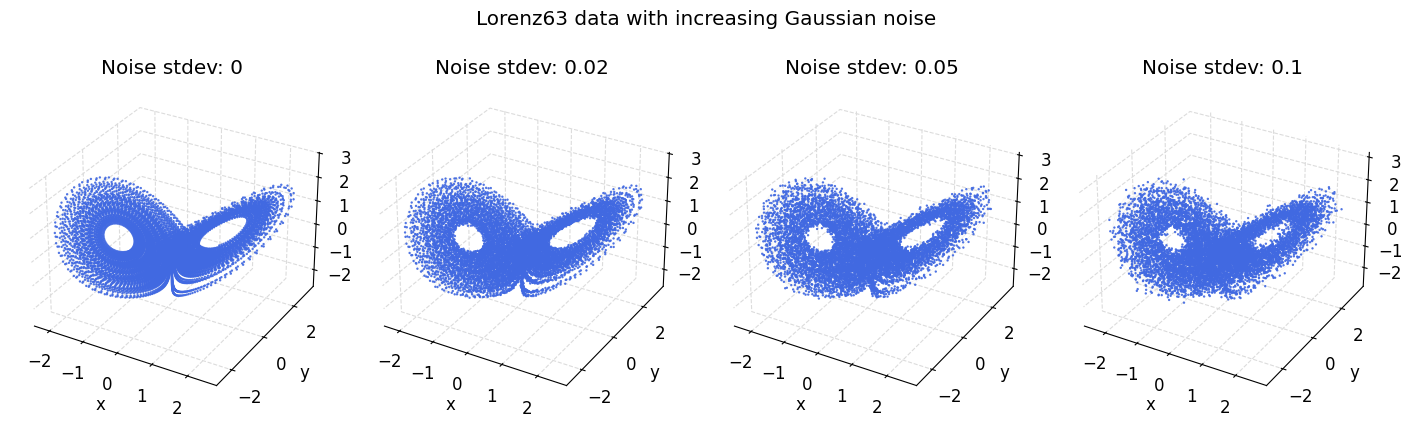

In [8]:
def plot_noise(ax, noise_amp, dataset):
    u = dataset.u[0]
    u_orig = standardize(u)
    u_noise = standardize(add_noise(u, noise_amp))
    ax.plot(*u_orig.T, linewidth=0.1, color="lightgray", alpha=0.7)
    ax.scatter(*u_noise.T, s=0.5, color="royalblue", alpha=0.9)
    set_labels(ax, ("x", "y", "z"))
    return ax


noise_amplitudes = (0, 0.02, 0.05, 0.10)
fig = comparisonplot(
    noise_amplitudes,
    dataset_loaded,
    plot_fn=plot_noise,
    title_fn=lambda a, _: f"Noise stdev: {a}",
    figsize=(14, 4.5),
    subplot_kw={"projection": "3d"},
)
fig.suptitle("Lorenz63 data with increasing Gaussian noise")

Text(0.5, 0.98, 'Lorenz63 data with increasing sparsity')

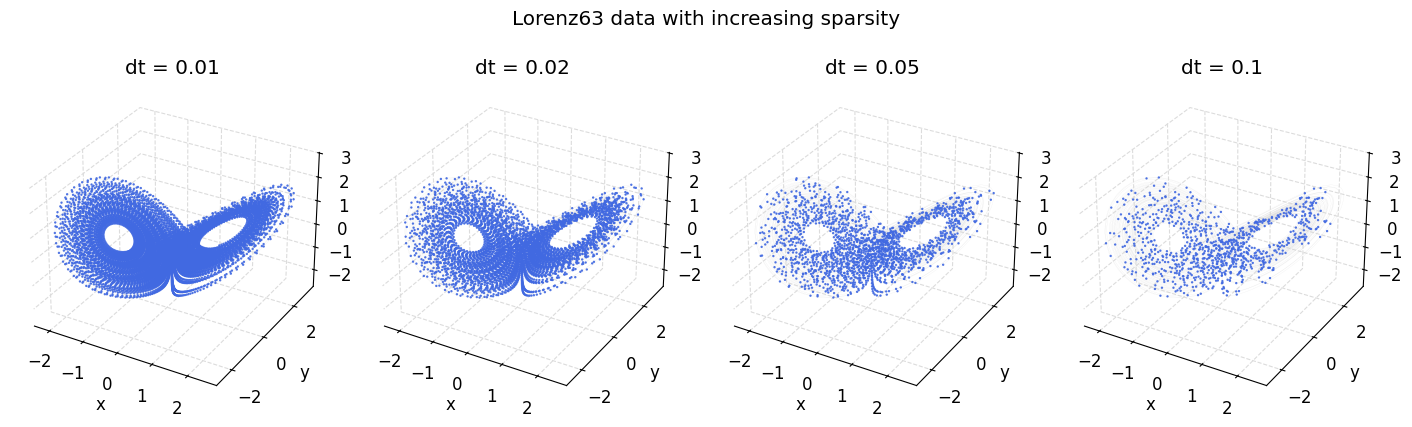

In [7]:
def plot_downsample(ax, downsample_factor, dataset):
    u = dataset.u[0]
    u_orig = standardize(u)
    u_dwnsmaple = standardize(downsample(u, downsample_factor))
    ax.plot(*u_orig.T, linewidth=0.1, color="lightgray", alpha=0.7)
    ax.scatter(*u_dwnsmaple.T, s=0.5, color="royalblue", alpha=0.9)
    set_labels(ax, ("x", "y", "z"))
    return ax


downsample_factors = (1, 2, 5, 10)
fig = comparisonplot(
    downsample_factors,
    dataset_loaded,
    plot_fn=plot_downsample,
    title_fn=lambda dwnsample, d: f"dt = {round(d.t[0][1] - d.t[0][0], 2) * dwnsample}",
    figsize=(14, 4.5),
    subplot_kw={"projection": "3d"},
)
fig.suptitle("Lorenz63 data with increasing sparsity")
